# Problem Set 5
In this problem set you will implement the Conditional Gradient algorithm, also known as the Frank Wolfe algorithm, and you will compare it to algiorithms you have implemented on previous homeworks. You will also play with Mirror Descent.

# Problem 1: LASSO via Frank Wolfe
Recall the least squares problem with $\ell^1$ regularization from the previous two homeworks:
$$
\min_x \left[f(x) = \frac{1}{2}\|{Ax-b}\|_2^2 + \lambda \|{x}\|_1 \right]
$$

So far you have used the subgradient method, ISTA and FISTA (proxima gradient, and accelerated proximal gradient) to solve this problem. Now you will use Frank-Wolfe.

As we cover in the lectures, the Frank-Wolfe (or conditional gradient) algorithm minimizes a smooth function $f(x)$ subject to a convex constraint $x \in \mathcal{X}$.

When it is easy to minimize a linear function over $\mathcal{X}$, Frank-Wolfe (FW) has several advantages including that it often produces sparse iterates and does not require a projection step to stay within $\mathcal{X}$. In order to apply FW to the LASSO problem above, we can reformulate the problem as

\begin{eqnarray*}
\min_{{x}}: && \frac{1}{2}\|A{x}-{b}\|_2^2, \\
\mbox{s.t. } && \|{x}\|_1 \leq \gamma.
\end{eqnarray*}

This formulation is equivalent to the original LASSO formulation for a suitable value of $\gamma$ (and depending on the $\lambda$ in the original LASSO formulation).

Run the FW algorithm for $10^4$ steps and find a $\gamma$ that performs well empirically (you might consider the $\ell^1$ norm of your solution from previous homework. Compare the results to sub-gradient method implemented in the previous homework. Again, separately record the (unsquared) error $\|A{x}_t-{b}\|$ and the regularization term $\|{x}\|_1$.

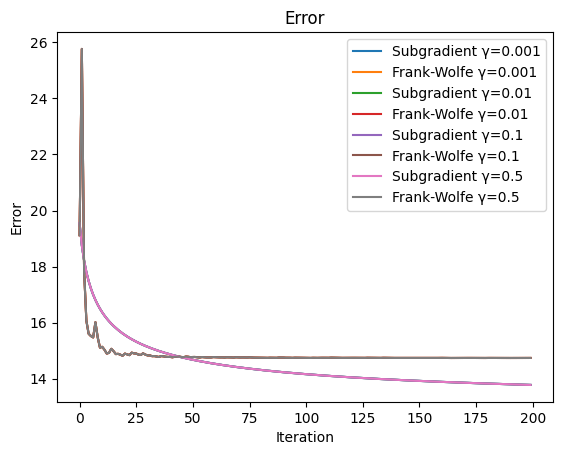

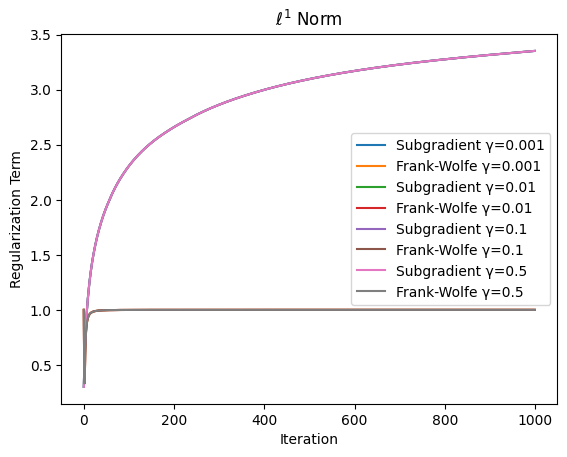

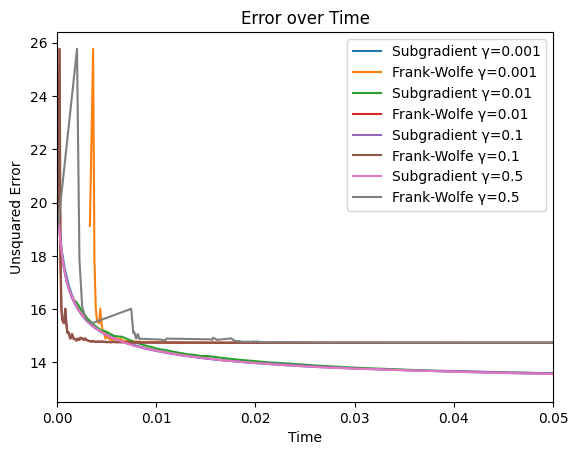

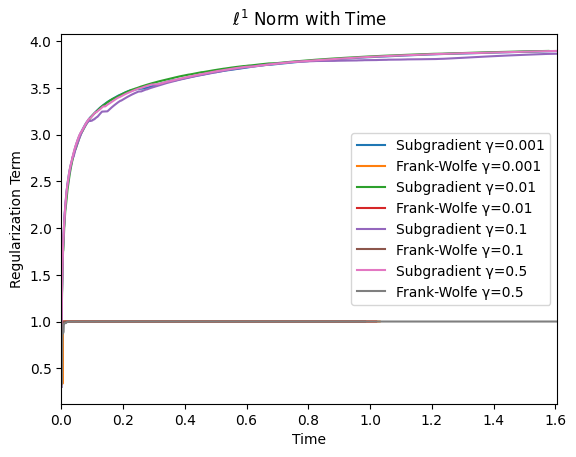

In [1]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import time

A = np.load("A.npy")
b = np.load("b.npy")

#adapted from previous homework to also receive gamma as a parameter
def optimize(update, A, b, reg, gamma, T=int(1e4)):
    x = np.zeros(A.shape[1])
    error = []
    l1 = []
    loss = []
    elapsed_time = []
    start=time.time()
    for t in range(T):
        x = update(x, A, b, t, reg, gamma)
        end=time.time()
        if (t % 1 == 0) or (t == T - 1):
            error.append(la.norm(np.dot(A, x) - b))
            l1.append(np.sum(abs(x)))
            loss.append(0.5*la.norm(np.dot(A, x) - b)+reg*np.sum(abs(x)))
            elapsed_time.append(end-start)
            assert not np.isnan(error[-1])
    return x, error, l1, elapsed_time, loss

#subgradient from previous homework
def subgradient_lasso(x, A, b, t, lam, gamma, c=1e-4):
    grad_l1=np.sign(x)
    grad_l1[np.where(x==0)]=np.random.rand()*2-1
    grad=np.dot(A.T,np.dot(A,x)-b)+lam*grad_l1
    eta=c/np.sqrt(t+1)
    #eta = c/(t+1)
    y=x-eta*grad
    # to return the best solution
    if (0.5*np.square(la.norm(np.dot(A,y)-b,2))+lam*np.sum(abs(y))) < (0.5*np.square(la.norm(np.dot(A,x)-b,2))+lam*np.sum(abs(x))):
      x=y
    return x


# Define the Frank-Wolfe algorithm
def frank_wolfe(x, A, b, t, lam, gamma, c=1e-4):
  # Calculate the gradient
  grad = A.T.dot(A.dot(x) - b)

  s = np.zeros_like(x)
  #idx = np.argmax(np.abs(grad))  # Find the index with the maximum gradient (in absolute value)
  #s[idx] = -np.sign(grad[idx]) if grad[idx] != 0 else 0  # Set the direction for the largest gradient component
  if gamma > 0:
    idx = np.argmax(np.abs(grad))
    s[idx] = -np.sign(grad[idx]) if grad[idx] != 0 else 0

  # step size
  eta = 2 / (t + 2)  # diminishing step size - general value for frank lasso

  # move towards s
  x_new = x + eta * (s - x)

  return x_new

# set regularization parameter and number of iterations
lam = 1e-6
T=int(1e4)

gammas = [0.001, 0.01, 0.1, 0.5]  # list of gamma values

# Initialize plots
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

for gamma in gammas:
  # Frank-Wolfe algorithm
  x_fw, error_fw, l1_fw, t_fw, loss_fw = optimize(frank_wolfe, A, b, lam, gamma, T=T)
  # Subgradient algorithm
  x_sg, error_sg, l1_sg, t_sg, loss_sg = optimize(subgradient_lasso, A, b, lam, gamma, T=T)

  # Plotting for each gamma
  ax1.plot(error_sg[:200], label=f'Subgradient γ={gamma}')
  ax1.plot(error_fw[:200], label=f'Frank-Wolfe γ={gamma}')

  ax2.plot(l1_sg[:1000], label=f'Subgradient γ={gamma}')
  ax2.plot(l1_fw[:1000], label=f'Frank-Wolfe γ={gamma}')

  ax3.plot(t_sg, error_sg, label=f'Subgradient γ={gamma}')
  ax3.plot(t_fw, error_fw, label=f'Frank-Wolfe γ={gamma}')

  ax4.plot(t_sg, l1_sg, label=f'Subgradient γ={gamma}')
  ax4.plot(t_fw, l1_fw, label=f'Frank-Wolfe γ={gamma}')

# plots
ax1.set(title='Error', xlabel='Iteration', ylabel='Error')
ax1.legend()
ax2.set(title='$\ell^1$ Norm', xlabel='Iteration', ylabel='Regularization Term')
ax2.legend()
ax3.set(title='Error over Time', xlabel='Time', ylabel='Unsquared Error')
ax3.legend()
ax3.set_xlim(0, 0.05)
ax4.set(title='$\ell^1$ Norm with Time', xlabel='Time', ylabel='Regularization Term')
ax4.legend()
ax4.set_xlim(0, min(t_sg[-1], t_fw[-1]))

plt.show()

#Problem 2: Robust Regression, PSGD and Mirror Descent
Consider the problem of robust regression, where some small number of measurements have been potentially completely corrupted. One way to formulate an optimization problem to solve this robust regression is as follows:

\begin{eqnarray*}
\min_{\beta}: && \|X \beta - \mathbf{y}\|_1 \\
{\rm s.t.}: && \beta \in \mathcal{X}.
\end{eqnarray*}

The rationale for this formulation stems from the idea that because of the $\ell^1$-error, huge errors are not disproportionally penalized, as they would be in the squared error formulation (this is the formulation we have worked with before, including in the previous problem), and therefore the optimal solution is less sensitive to outliers. You will solve this problem using Projected Subgradient Descent, and also Mirror Descent. Let the constraint set be the simplex:
$$
\mathfrak{X} = \{\beta \,:\, \beta \geq 0, \, \sum \beta_i = 1\}.
$$





##Part (A)
Write down the update for projected gradient descent.

In [2]:
import numpy as np

#PSGD - will still use diminishing step size
def projected_gradient_descent(X, y, beta_init, step_size_init, iterations, gamma=0.5):
  beta = beta_init
  l1 = []
  elapsed_time = []
  start=time.time()

  for t in range(1, iterations + 1):
    # diminish step size -
    step_size = step_size_init / (t ** gamma)
    # Compute subgradient
    subgrad = X.T.dot(np.sign(X.dot(beta) - y))

    # Update beta using the subgradient
    beta = beta - step_size * subgrad
    # Project beta back onto the simplex
    beta = project_simplex(beta)
    end=time.time()

    l1_value = np.linalg.norm(X @ beta - y, 1)
    l1.append(l1_value)

  elapsed_time.append(end-start)

  return beta, l1, elapsed_time

def project_simplex(v):
  # project onto the simplex {w: w >= 0, sum(w) = 1}.
  if np.sum(v) <= 1 and np.alltrue(v >= 0):
    return v  # Already in the simplex

  #sort 'v' in descending order to prepare for finding the cumulative sum that satisfies the simplex conditions
  u = np.sort(v)[::-1]
  #compute the cumulative sum of the sorted vector and subtract 1 to help finding theta
  cssv = np.cumsum(u) - 1

  #get p
  rho = np.nonzero(u * np.arange(1, len(u) + 1) > cssv)[0][-1]
  #projected vector to sum to 1
  theta = cssv[rho] / (rho + 1)

  #ensure it will be a positive value
  return np.maximum(v - theta, 0)




##Part (B)
Write down the mirror descent update. For this, we will use the mirror map $\Phi(\beta) = \sum \beta_i \log \beta_i$. Compute the Bregman divergence, $D_{\phi}(\mathbf{\beta},\mathbf{z})$ explicitly. <br>
(We use $\mathbf{z}$ here to not confuse this variable with $\mathbf{y}$ in the robust regression problem above. $\mathbf{z}$ is the intermediate term used in Mirror Descent, which was commonly denoted as $\mathbf{y}$ in the lectures.)

In [3]:
def mirror_descent_update(X, beta, y, step_size):
  #added epislon to prevent the log(0) issue
  epsilon=1e-8
  subgrad = X.T.dot(np.sign(X.dot(beta) - y))
  beta_adjusted = np.clip(beta, epsilon, 1-epsilon)
  z = beta_adjusted * np.exp(-step_size * subgrad)
  z /= np.sum(z)  # to ensure it sums up to 1
  return z

def mirror_descent(X, y, beta_init, step_size, iterations):
  beta = beta_init
  l1 = []
  elapsed_time = []
  start=time.time()

  for t in range(iterations):
    beta = mirror_descent_update(X, beta, y, step_size)
    end=time.time()
    l1_value = np.linalg.norm(X @ beta - y, 1)
    l1.append(l1_value)
    #l1.append(np.sum(abs(beta)))

  elapsed_time.append(end-start)

  return beta, l1, elapsed_time



##Part (C)
Using the data in X.npy and y.npy, and using stepsizes of your choosing, compare the projected subgradient method with mirror descent. What is $\beta$? Plot the objective above against iterations for both methods (in a single plot).

In [4]:
X = np.load("X.npy")
y = np.load("y.npy")

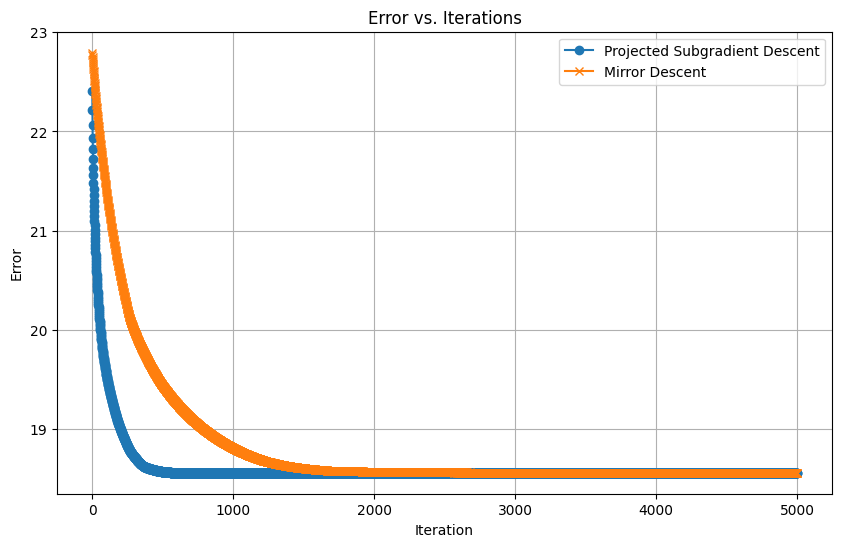

[0.04697819 0.06170133 0.05158132 0.04750719 0.03619991 0.05557443
 0.037516   0.07695557 0.08252272 0.03283515 0.06811783 0.04498058
 0.0491269  0.07916233 0.00622426 0.00746731 0.0016611  0.07187466
 0.06652961 0.07466548]
[0.04692182 0.06188157 0.0517616  0.04751067 0.0363243  0.05556676
 0.03751027 0.07696994 0.082823   0.03284118 0.06813985 0.04496756
 0.04912352 0.07916782 0.00621631 0.00746631 0.00165677 0.07190285
 0.06656044 0.07468746]


In [ ]:
# Initializations

#beta init to align with X={β:β≥0,∑βi=1},
beta_init = np.full(X.shape[1], 1/X.shape[1])
step_size_psgd = 0.0001  # Step size for PSGD
step_size_md = 0.0001  # Step size for Mirror Descent
T = 5000

beta_psgd, l1_psgd, t_psgd = projected_gradient_descent(X, y, beta_init, step_size_psgd, T)
beta_md, l1_md, t_md = mirror_descent(X, y, beta_init, step_size_md, T)

# Plot the objective function values against iterations
plt.figure(figsize=(10, 6))
plt.plot(l1_psgd, label='Projected Subgradient Descent', marker='o')
plt.plot(l1_md, label='Mirror Descent', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()

print(beta_psgd)
print(beta_md)


The values in the
β vector are the proportions of each feature's importance according to the optimized solution found by PSGD and Mirror Descent, respectively, adhering to the simplex constraint. The simplex constraint ensures that all these coefficients are non-negative and sum up to 1.
In other words:
The vector Beta β is the final state of the coefficients after the last iteration of the Mirror Descent optimization process. Each value in this vector represents the weight or importance assigned to the corresponding feature in your regression model.

Length of β is the number of columns in X.